# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
3
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import jacobi_constant, calculate_errors_per_orbit
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances, find_nearest_orbits_batch, calculate_pairwise_distances, calculate_distances_batch, find_nearest_points, find_nearest_points_batch
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, reduce_dimensions_latent_space, compute_centroids, interpolate_sample
from orbit_generation.convergence import process_diferential_correction_orbits

In [3]:
import numpy as np
import pandas as pd
import os
from pytorch_lightning import Trainer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Parameters

In [4]:
want_to_train = False   # Set this parameter to False if you want to load the model from the folder
want_to_generate = False    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = False   # Set this parameter to False if you don't want to calculate any metric
want_to_get_cluster_metrics = False    # Set this parameter to False if you don't want to calculate clustering metrics
want_to_perform_convergence = False   # Set this parameter to False if you don't want to perform convergence

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 0.1,
    'lr': 0.001,
    'dropout_rate': 0.2,
    'samples_to_generate' : 100,
    'distance_metric' : 'euclidean',
    'max_iter_convergence' : 50
}

# Saving paths

In [7]:
# Experiment
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

Parameters already exist for experiment: ../experiments/experiment_13


In [8]:
# Images
## Orbits
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.png')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
generated_orbits_that_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_converged.png')
generated_orbits_that_did_not_converged_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits_that_not_converged.png')
## Latent Spaces
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
combined_latent_space_arrows_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space_arrows')
family_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids')
family_feature_centroids_plot_path = os.path.join(images_folder, f'exp{experiment_id}_family_feature_centroids')
## Other
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')

# Model
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')

# Orbits
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
refined_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits.npy')

# Latent Representations
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
family_centroids_path = os.path.join(images_folder, f'exp{experiment_id}_family_centroids.npy')

# Features
generation_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_generation_df.csv')
refined_orbits_df_path = os.path.join(experiment_folder, f'exp{experiment_id}_refined_orbits_df.csv')


# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [10]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [11]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [12]:
model = get_model(params)

In [13]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

In [14]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
    loss_history.plot_all_losses(save_path=model_losses_path)
else:
    model.load_state_dict(torch.load(model_save_path, weights_only=True))  

## Generate

In [15]:
if want_to_generate:
    # Generate the orbits
    generation = model.sample(params['samples_to_generate'])
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

(100, 7, 100)

# Analysis of Generation

## Visualization

In [16]:
if torch.is_tensor(generation):
    generation=generation.detach().numpy()

if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:]
    generation.shape
else:
    no_time_generation = generation

no_time_generation.shape

(100, 6, 100)

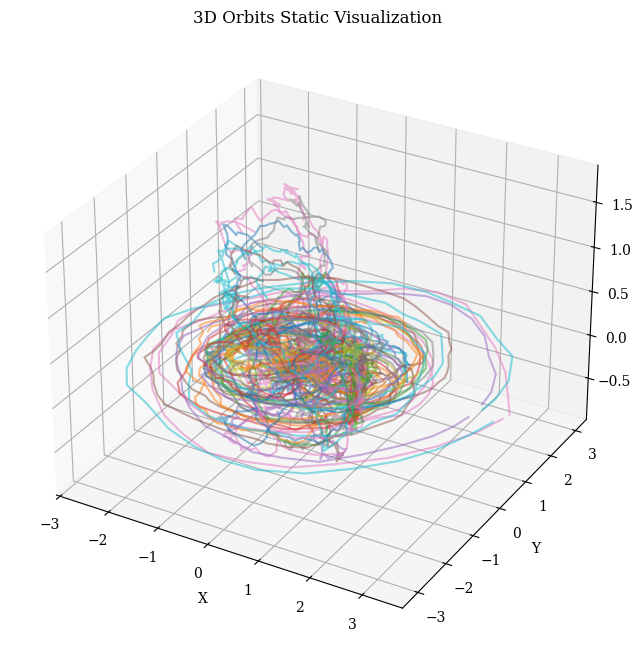

In [17]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

In [18]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_13/images/exp13_generated_orbits.html


## Coverage

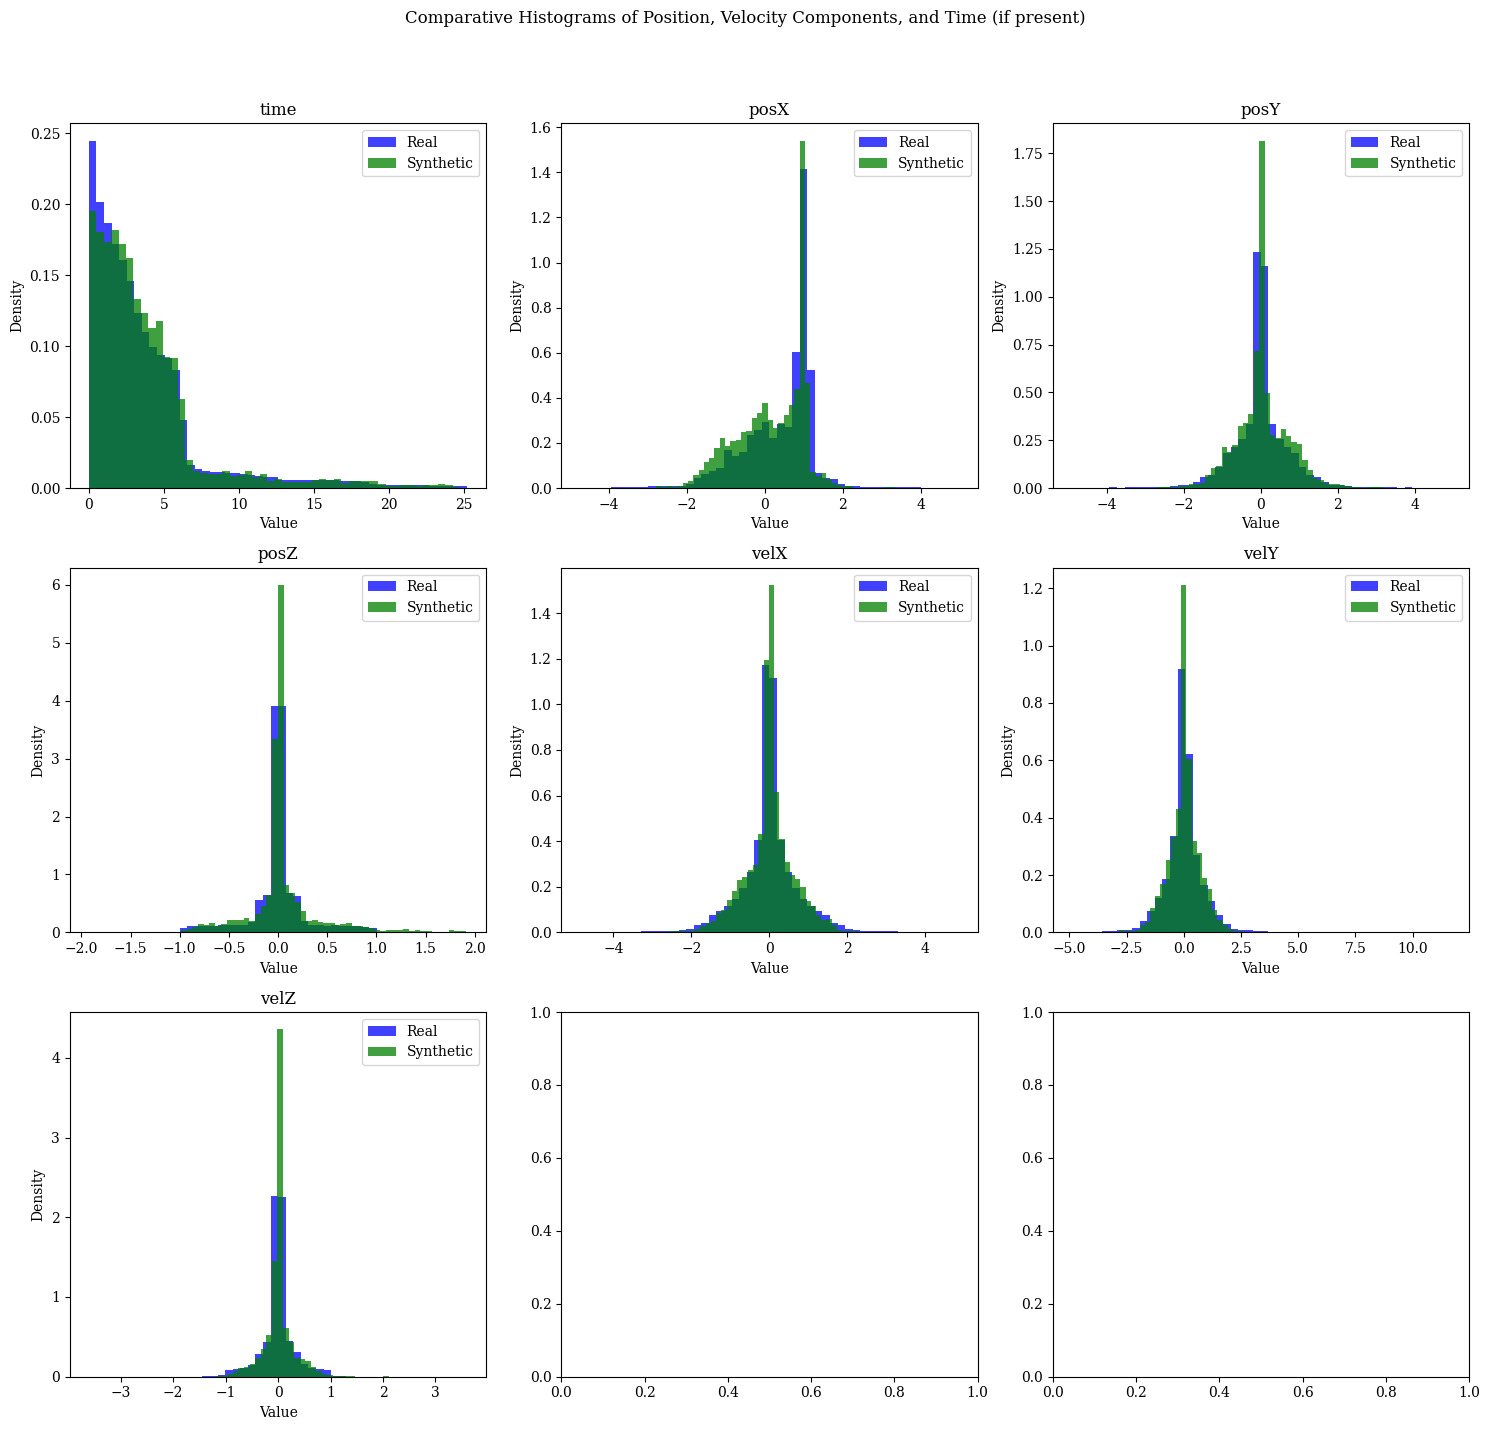

In [19]:
plot_histograms_comparison(data1=data, data2=generation, label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

## Pheasibility

In [20]:
if calculate_error_metrics:

    #Order metrics
    reordered_generation, order_metrics_array, order_metric_labels = reorder_orbits(generation)
    average_order_metrics = order_metrics_array.mean(axis=0)
    average_order_metrics_dict = dict(zip(order_metric_labels, average_order_metrics))

    # Pheasibility metrics
    per_orbit_errors = calculate_errors_per_orbit(reordered_generation,EM_MU)
    mean_errors = {key: np.mean(value) for key, value in per_orbit_errors.items()}
    generation_df = pd.DataFrame(per_orbit_errors)
    new_values_df = pd.DataFrame(order_metrics_array, columns=order_metric_labels)
    generation_df = pd.concat([generation_df, new_values_df], axis=1)

    add_experiment_metrics(experiments_folder, params=params, metrics={**mean_errors, **average_order_metrics_dict})

else:
    generation_df = pd.read_csv(generation_df_path)



In [21]:
generation_df.head()

,position_error,velocity_error,energy_error,disorder_metric,correct_order,inversions,kendall_tau_distance,nearest_orbit,nearest_orbit_distance
0,0.044936,0.093646,0.074092,204.0,66.0,133.0,0.053737,0,6.745636
1,0.052754,0.154923,0.151754,400.0,61.0,252.0,0.101818,0,6.854908
2,0.108428,0.184346,0.110844,166.0,67.0,113.0,0.045657,0,10.211395
3,0.161681,0.280255,0.334736,210.0,71.0,136.0,0.054949,0,9.275817
4,0.090926,0.138620,0.231564,174.0,74.0,106.0,0.042828,0,8.578484


# Latent Space

In [22]:
latent_means, latent_log_vars = model.encode(scaled_data)
latent_means = latent_means.detach().numpy()
latent_log_vars = latent_log_vars.detach().numpy()
latent_representation = np.concatenate((latent_means, latent_log_vars), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:304: UserWarning:

Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)



(45211, 4)

In [23]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

In [24]:
# Compute centroids
centroid_means = compute_centroids(latent_means, orbits_id_classes, method='mean')
centroid_log_vars = compute_centroids(latent_log_vars, orbits_id_classes, method='mean')
centroids_representation = np.concatenate((centroid_means, centroid_log_vars), axis=1)
np.save(family_centroids_path, centroids_representation)
centroids_representation.shape

(40, 4)

In [25]:
unique_classes = list(set(orbits_id_classes))
family_names=get_orbit_classes(unique_classes)[0]
len(family_names)

40

In [26]:
full_data_centroid = np.mean(latent_means, axis=0)
full_data_centroid

array([0.18348268, 0.05021718], dtype=float32)

## Visualize

Dataset

In [27]:
latent_log_vars = torch.from_numpy(latent_log_vars)
latent_stdevs = torch.exp(0.5 * latent_log_vars)
latent_stdevs = latent_stdevs.numpy()
latent_stdevs.shape

(45211, 2)

NameError: name 'Line2D' is not defined

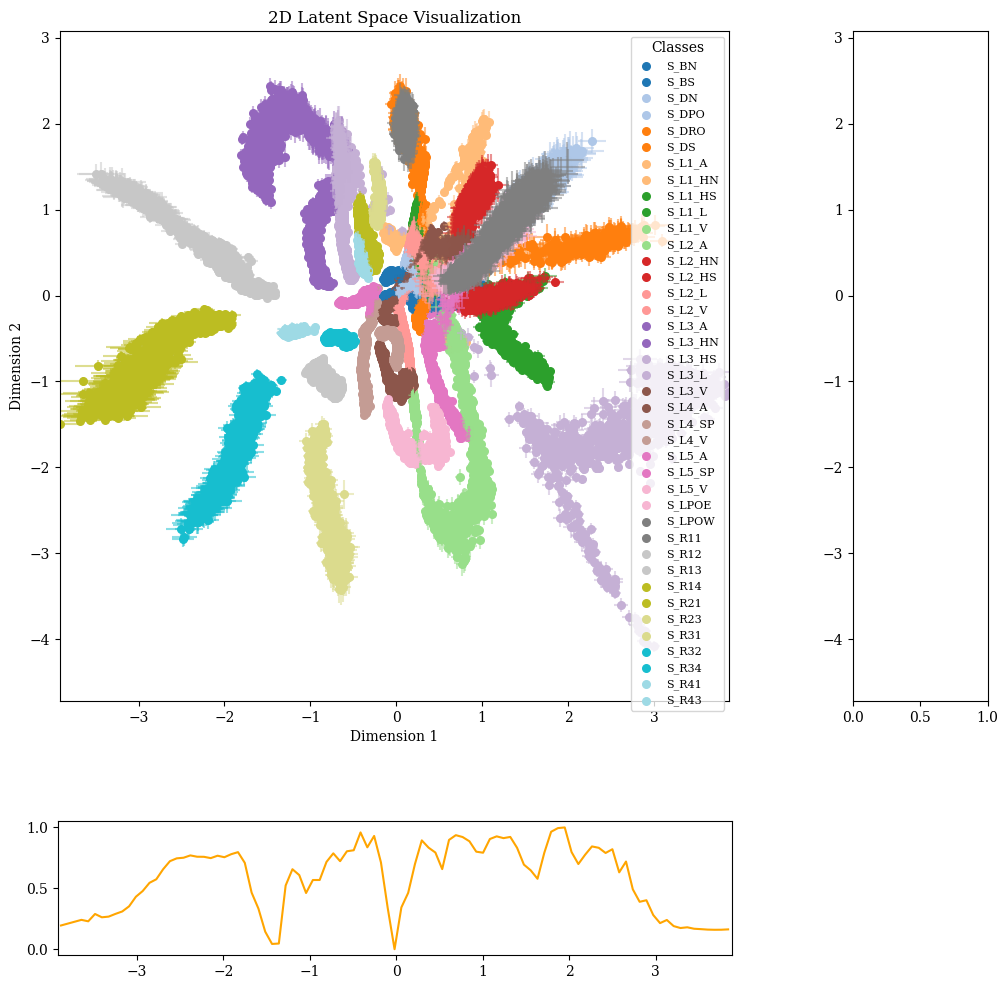

In [28]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(latent_means,
                            np.array(family_labels),
                            save_path=latent_space_path,
                            features=features,
                            feature_names=feature_names,
                            plot_std=False,
                            latent_stdevs=latent_stdevs)
else:
    rls=reduce_dimensions_latent_space(latent_means,
                                        np.array(family_labels),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=latent_space_path,
                                        show_legend=False)

Centroids

In [29]:
centroid_log_vars = torch.from_numpy(centroid_log_vars)
centroid_stdevs = torch.exp(0.5 * centroid_log_vars)
centroid_stdevs = centroid_stdevs.numpy()
centroid_stdevs.shape

(40, 2)

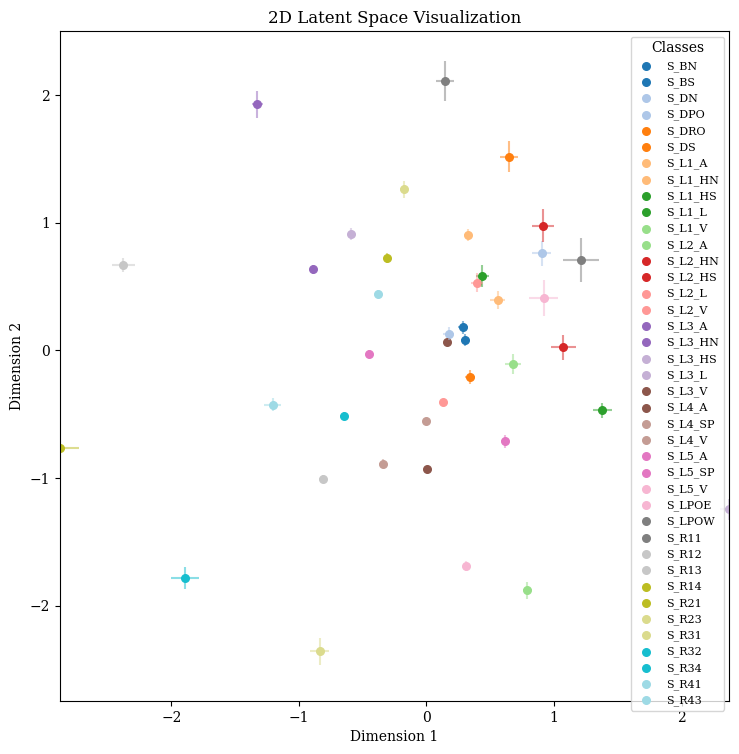

In [30]:
if latent_means.shape[1]==2:
    plot_2d_latent_space(centroid_means,
                            np.array(family_names),
                            save_path=family_centroids_plot_path,
                            latent_stdevs=centroid_stdevs
                            )
else:
    rls=reduce_dimensions_latent_space(centroid_means,
                                        np.array(family_names),
                                        techniques=['PCA','UMAP','t-SNE'],
                                        save_path=family_centroids_plot_path,
                                        show_legend=False)

## Clustering

In [31]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_means, [family_labels], label_names=['family'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

# Convergence

In [32]:
if want_to_perform_convergence:
    refined_orbits, refined_orbits_df= process_diferential_correction_orbits(np.transpose(reordered_generation,(0,2,1)),
                                                                        EM_MU,
                                                                        max_iter=params['max_iter_convergence'])
    refined_orbits = np.transpose(refined_orbits,(0,2,1))
    np.save(refined_data_path, refined_orbits)
else:
    refined_orbits = np.load(refined_data_path)
    refined_orbits_df = pd.read_csv(refined_orbits_df_path)

refined_orbits.shape

(46, 7, 100)

Order Metrics

In [33]:
# Order orbits and average metrics
reordered_refined_orbits, refined_order_metrics_array, refined_order_metric_labels = reorder_orbits(refined_orbits)
refined_average_order_metrics = refined_order_metrics_array.mean(axis=0)
refined_order_metrics = dict(zip(refined_order_metric_labels, refined_average_order_metrics))

# Add individual metrics to the df
new_values_df = pd.DataFrame(refined_order_metrics_array, columns=refined_order_metric_labels)
refined_orbits_df = pd.concat([refined_orbits_df, new_values_df], axis=1)

refined_order_metrics

{'disorder_metric': np.float64(202.7391304347826),
 'correct_order': np.float64(74.67391304347827),
 'inversions': np.float64(133.69565217391303),
 'kendall_tau_distance': np.float64(0.054018445322793006)}

Pheasibility Metrics

In [34]:
refined_per_orbit_errors = calculate_errors_per_orbit(reordered_refined_orbits,EM_MU)
refined_orbits_df['propagated_position_error'] = refined_per_orbit_errors['position_error']
refined_orbits_df['propagated_velocity_error'] = refined_per_orbit_errors['velocity_error']
refined_orbits_df['propagated_energy_error'] = refined_per_orbit_errors['energy_error']
refined_mean_errors = {key: np.mean(value) for key, value in refined_per_orbit_errors.items()}
refined_mean_errors

{'position_error': np.float64(4.967661336234329e-12),
 'velocity_error': np.float64(1.006296837133638e-11),
 'energy_error': np.float64(2.937470147083131e-11)}

In [35]:
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,calculated_jacobi,period_distance_with_generation,feature_distance_from_closest,closest_feature_indices,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,disorder_metric,correct_order,inversions,kendall_tau_distance
0,0,4.517193,4.408274,13,3.425201e-10,1.091727,0.026502,-0.045054,0.033199,-0.119585,-0.064925,1.117204,-0.079060,-1.037362e-01,-0.159310,-0.197419,-2.965951e-01,220.0,61.0,143.0,0.057778,2.531853e-12,6.885720e-12,1.935852e-12,2.984220,0.108918,0.000090,13003,0,7.113193,2.144939,0.949475,220.0,61.0,143.0,0.057778
1,2,6.081447,6.093807,6,8.393596e-11,0.765791,-0.062566,-0.300177,-0.089754,-0.046112,-0.773538,0.879347,-0.059126,-2.415599e-01,-0.082026,-0.182004,-7.600174e-01,104.0,75.0,66.0,0.026667,1.526021e-12,5.227806e-12,5.984645e-12,2.395489,0.012360,0.000979,12570,0,9.997017,2.543358,1.908640,104.0,75.0,66.0,0.026667
2,4,5.969552,5.799934,8,3.155458e-13,0.730357,0.013235,-0.205358,-0.012986,0.241850,-0.361215,0.880567,-0.013873,-3.554353e-01,-0.034182,-0.020970,-4.391288e-01,222.0,73.0,147.0,0.059394,1.292439e-12,3.252634e-12,2.332590e-14,2.714493,0.169619,0.000037,12670,0,8.356507,2.998624,1.362013,222.0,73.0,147.0,0.059394
3,5,6.518158,6.238204,10,2.595689e-10,-1.811148,0.151417,-0.046776,0.051786,1.402418,0.072901,-1.677355,0.129247,5.101010e-09,0.121676,1.248164,-1.050935e-10,188.0,78.0,130.0,0.052525,1.847805e-12,8.638641e-12,5.048687e-11,2.461519,0.279954,0.000004,22681,0,23.384367,4.519528,1.509227,188.0,78.0,130.0,0.052525
4,7,4.239129,6.337604,31,8.436388e-13,-0.470492,0.175187,-0.754298,0.204873,1.011473,0.086243,0.044747,0.396483,-1.018880e-01,0.968640,1.244493,1.341746e+00,578.0,63.0,372.0,0.150303,1.770958e-12,4.764018e-12,1.437797e-12,0.687834,2.098476,0.031454,30655,0,21.225327,15.175562,0.540606,578.0,63.0,372.0,0.150303


In [36]:
refined_ids = refined_orbits_df['id'].astype(int).tolist()
generated_data_that_was_refined = generation[refined_ids]
generated_data_that_was_refined.shape

(46, 7, 100)

## Visualization

Generation that was able to get Refined

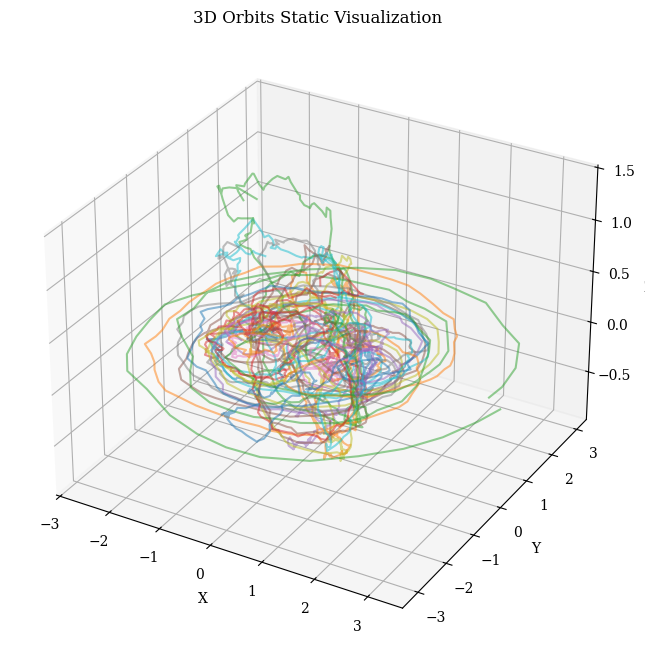

In [37]:
visualize_static_orbits(generated_data_that_was_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_converged_path)

Refinement

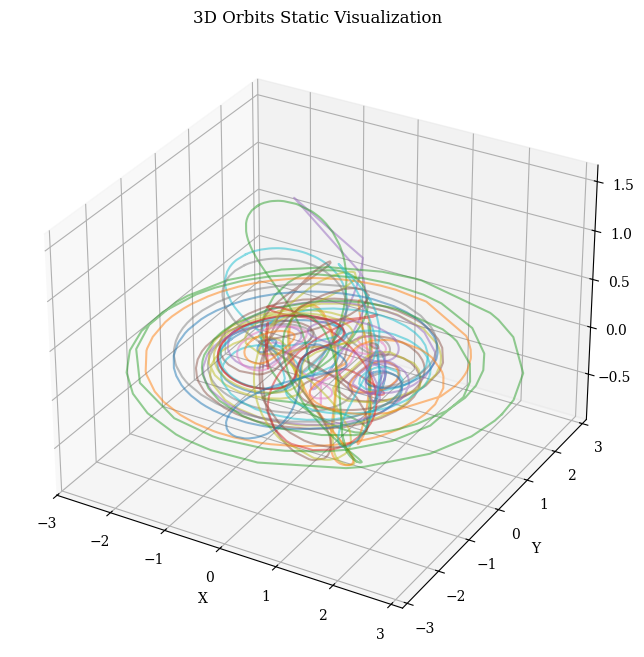

In [38]:
visualize_static_orbits(reordered_refined_orbits[:,1:,:], show_legend=False, save_path=refined_orbits_path)

Generation that didn't manage to get refined

In [39]:
non_refined_ids = sorted(set(range(params['samples_to_generate'])) - set(refined_ids))
generated_data_that_was_not_refined = generation[non_refined_ids]
generated_data_that_was_not_refined.shape

(54, 7, 100)

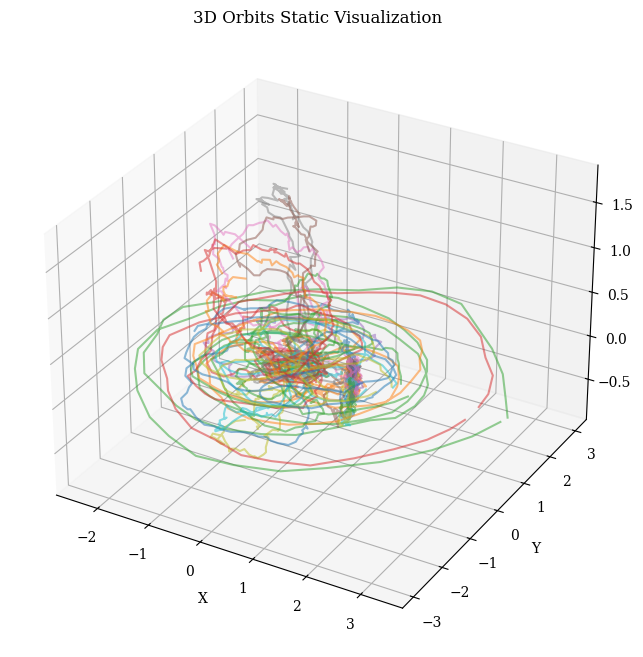

In [40]:
visualize_static_orbits(generated_data_that_was_not_refined[:,1:,:], show_legend=False, save_path=generated_orbits_that_did_not_converged_path)

## Latent Space

In [43]:
refined_scaled_data = scaler.transform(torch.from_numpy(refined_orbits).float())
refined_latent_means, refined_latent_log_vars = model.encode(refined_scaled_data)
refined_latent_means = refined_latent_means.detach().numpy()
refined_latent_log_vars = refined_latent_log_vars.detach().numpy()
refined_latent_representations = np.concatenate((refined_latent_means, refined_latent_log_vars), axis=1)
refined_latent_representations.shape

(46, 4)

Saved plot to ../experiments/experiment_13/images/exp13_combined_latent_space


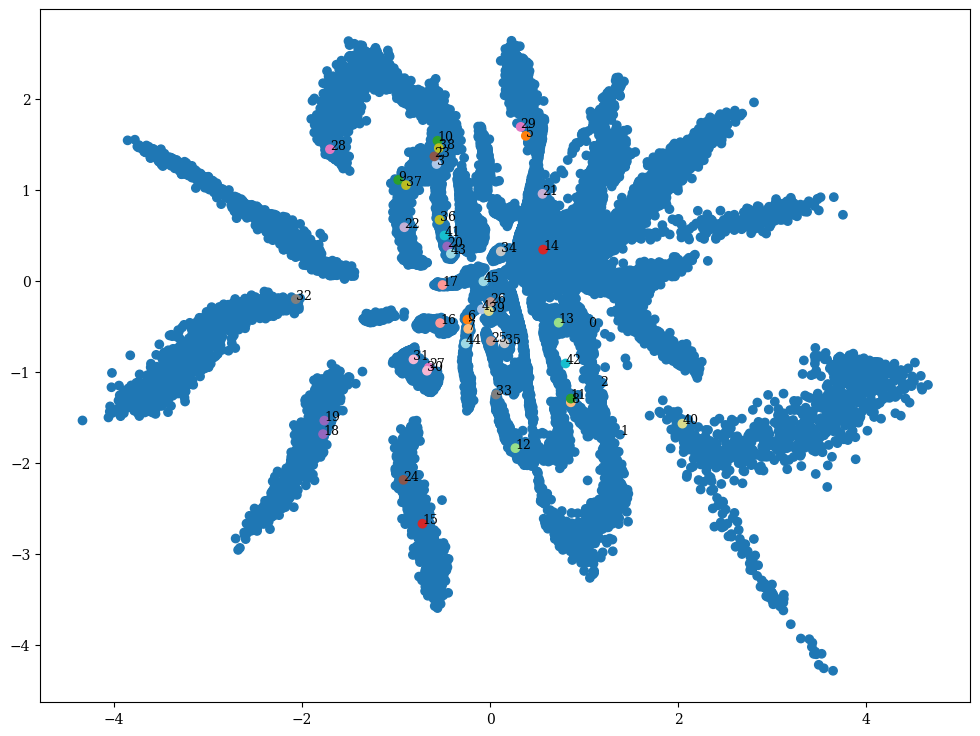

In [127]:
if refined_latent_means.shape[1]>2:
    rls=reduce_dimensions_latent_space(train_latent=latent_representation,
                                        val_latent=refined_latent_means)
    latent_representation=rls['PCA']['train']
    refined_latent_means=rls['PCA']['val']

plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=refined_latent_means,
    synthetic_labels=list(range(0, len(refined_scaled_data))),
    annotation_mode='numbers',
    save_path=combined_latent_space_path
)

In [74]:
scaled_generation = scaler.transform(torch.from_numpy(generation).float())
latent_generation_means, _ = model.encode(scaled_generation)
latent_generation_means = latent_generation_means.detach().numpy()
latent_generation_means_that_refined = latent_generation_means[refined_ids]
generation_to_refinement = np.stack((latent_generation_means_that_refined, refined_latent_means), axis=1)
generation_to_refinement.shape

(46, 2, 2)

Saved plot to ../experiments/experiment_13/images/exp13_combined_latent_space


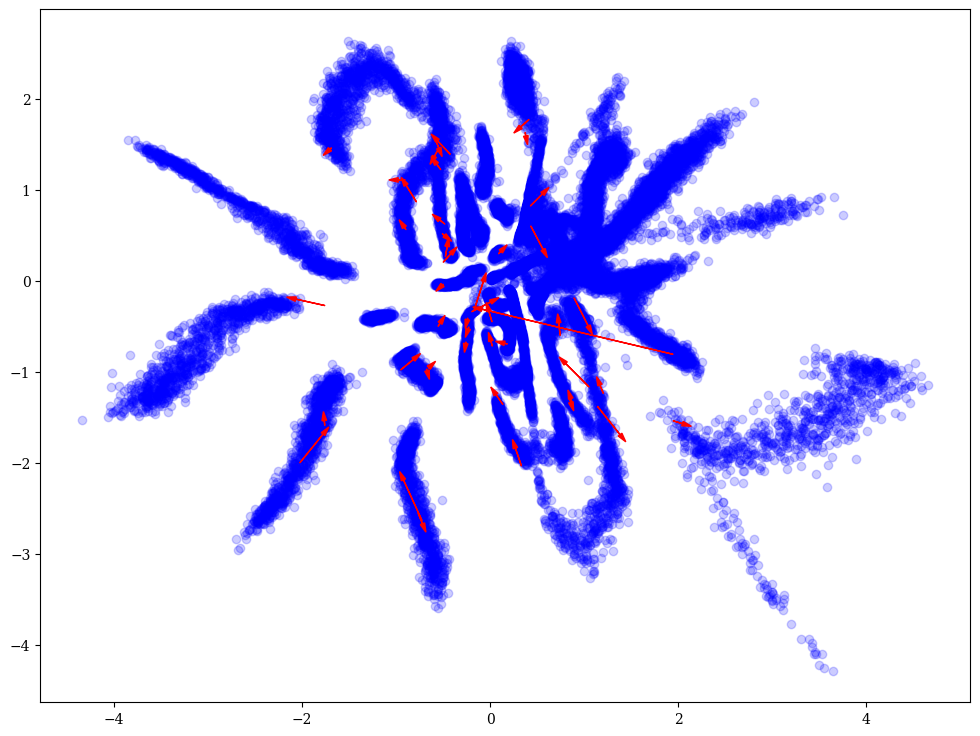

In [126]:
plot_combined_2d_latent_space(
    real_latent=latent_means, 
    synthetic_latent=generation_to_refinement,
    annotation_mode='numbers',
    save_path=combined_latent_space_arrows_path
)

## Features

Calculate Jacobi Constant on the dataset

In [46]:
results = np.array([jacobi_constant(np.transpose(data[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

,id_class,x_0,y_0,x_0,vx_0,vy_0,vz_0,jacobi,period,stability,propagated_periods,calculated_jacobi
0,1.0,0.941000,1.900442e-23,0.509474,2.968938e-13,-0.124968,-3.122717e-12,2.745412,11.555291,211.184678,3.0,2.757415
1,1.0,0.941538,-8.592698e-24,0.508602,2.902340e-13,-0.125672,-3.252212e-12,2.746226,11.551622,210.329145,3.0,2.758229
2,1.0,0.942076,6.956604e-24,0.507729,2.685527e-13,-0.126375,-2.862050e-12,2.747039,11.547936,209.473685,3.0,2.759042
3,1.0,0.942613,1.763946e-24,0.506856,3.153637e-13,-0.127078,-3.791054e-12,2.747850,11.544233,208.618315,3.0,2.759853
4,1.0,0.943150,9.441804e-24,0.505982,2.663322e-13,-0.127781,-2.982720e-12,2.748660,11.540511,207.763051,3.0,2.760663


Calculate Jacobi Constant and Period on the Refined Orbits

In [47]:
new_jacobis = np.array([jacobi_constant(np.transpose(refined_orbits[:,1:,:],(0,2,1))[i][0], EM_MU)[0] for i in range(refined_orbits.shape[0])])
refined_orbits_df['calculated_jacobi'] = new_jacobis
refined_orbits_df.rename(columns={'new_period': 'period'}, inplace=True)
refined_orbits_df['period_distance_with_generation'] = abs(refined_orbits_df['period'] - refined_orbits_df['old_period'])
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,calculated_jacobi,period_distance_with_generation,feature_distance_from_closest,closest_feature_indices,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,disorder_metric,correct_order,inversions,kendall_tau_distance
0,0,4.517193,4.408274,13,3.425201e-10,1.091727,0.026502,-0.045054,0.033199,-0.119585,-0.064925,1.117204,-0.079060,-1.037362e-01,-0.159310,-0.197419,-2.965951e-01,220.0,61.0,143.0,0.057778,2.531853e-12,6.885720e-12,1.935852e-12,2.984220,0.108919,0.000090,13003,0,7.113193,2.144939,0.949475,220.0,61.0,143.0,0.057778
1,2,6.081447,6.093807,6,8.393596e-11,0.765791,-0.062566,-0.300177,-0.089754,-0.046112,-0.773538,0.879347,-0.059126,-2.415599e-01,-0.082026,-0.182004,-7.600174e-01,104.0,75.0,66.0,0.026667,1.526021e-12,5.227806e-12,5.984645e-12,2.395489,0.012360,0.000979,12570,0,9.997017,2.543358,1.908640,104.0,75.0,66.0,0.026667
2,4,5.969552,5.799934,8,3.155458e-13,0.730357,0.013235,-0.205358,-0.012986,0.241850,-0.361215,0.880567,-0.013873,-3.554353e-01,-0.034182,-0.020970,-4.391288e-01,222.0,73.0,147.0,0.059394,1.292439e-12,3.252634e-12,2.332590e-14,2.714493,0.169619,0.000037,12670,0,8.356507,2.998624,1.362013,222.0,73.0,147.0,0.059394
3,5,6.518158,6.238204,10,2.595689e-10,-1.811148,0.151417,-0.046776,0.051786,1.402418,0.072901,-1.677355,0.129247,5.101010e-09,0.121676,1.248164,-1.050935e-10,188.0,78.0,130.0,0.052525,1.847805e-12,8.638641e-12,5.048687e-11,2.461519,0.279954,0.000004,22681,0,23.384367,4.519528,1.509227,188.0,78.0,130.0,0.052525
4,7,4.239129,6.337604,31,8.436388e-13,-0.470492,0.175187,-0.754298,0.204873,1.011473,0.086243,0.044747,0.396483,-1.018880e-01,0.968640,1.244493,1.341746e+00,578.0,63.0,372.0,0.150303,1.770958e-12,4.764018e-12,1.437797e-12,0.687834,2.098476,0.031454,30655,0,21.225327,15.175562,0.540606,578.0,63.0,372.0,0.150303


Compare Features between Dataset and Refinement

In [48]:
import importlib
import orbit_generation.evaluation  # Import the module first

# Reload the module
importlib.reload(orbit_generation.evaluation)

# Re-import the functions after the module is reloaded
from orbit_generation.evaluation import (
    evaluate_clustering_multiple_labels,
    calculate_closest_feature_distances,
    find_nearest_orbits_batch,
    calculate_pairwise_distances,
    calculate_distances_batch,
    find_nearest_points,
    find_nearest_points_batch
)

Saved plot to ../experiments/experiment_13/images/exp13_family_feature_centroids


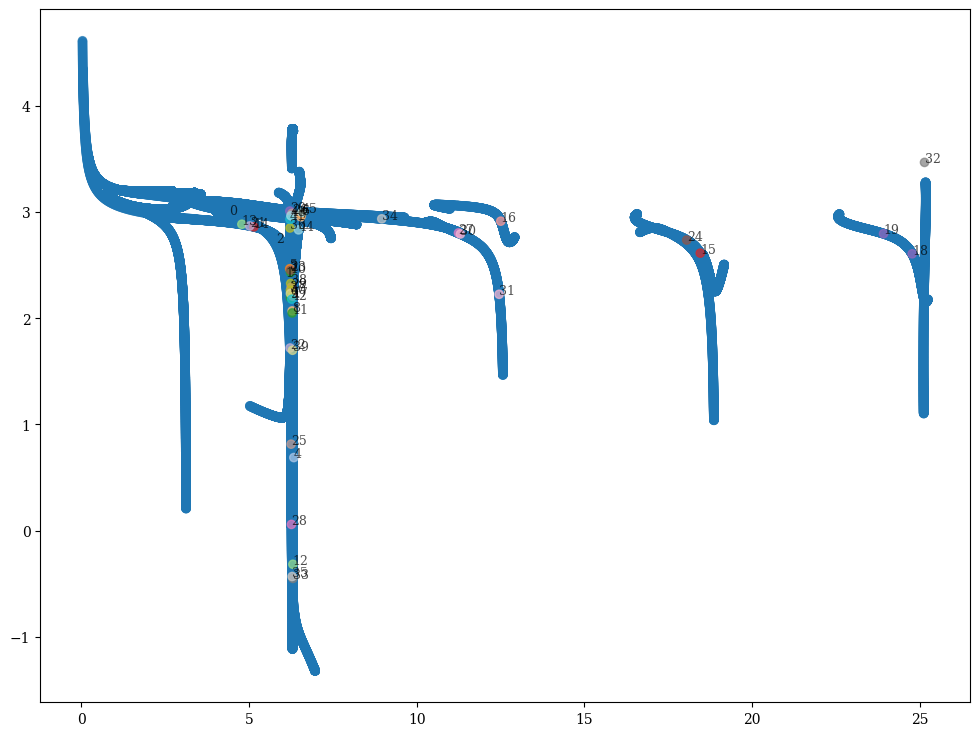

In [49]:
features_used = ['period', 'calculated_jacobi']

dataset_features = orbit_df[features_used].values
refined_orbits_features = refined_orbits_df[features_used].values 

closest_feature_indices, feature_distances = find_nearest_points_batch(refined_orbits_features, dataset_features,
                                                                       n=1, distance_metric=params['distance_metric'])

refined_orbits_df['feature_closest_orbit'] = closest_feature_indices
refined_orbits_df['feature_distance_from_closest_orbit'] = feature_distances

plot_combined_2d_latent_space(dataset_features, refined_orbits_features,
                              synthetic_labels=list(range(0, len(refined_scaled_data))),
                              annotation_mode='numbers', save_path=family_feature_centroids_plot_path)

Feature Centroids

In [50]:
array_features = orbit_df[features_used].to_numpy()
feature_centroid = orbit_df[features_used].mean().to_numpy()
feature_centroids = compute_centroids(array_features, orbits_id_classes, method='mean')
feature_centroids.shape

(40, 2)

In [51]:
stdev_centroids  = orbit_df.groupby('id_class')[features_used].std().values
stdev_centroids.shape

(40, 2)

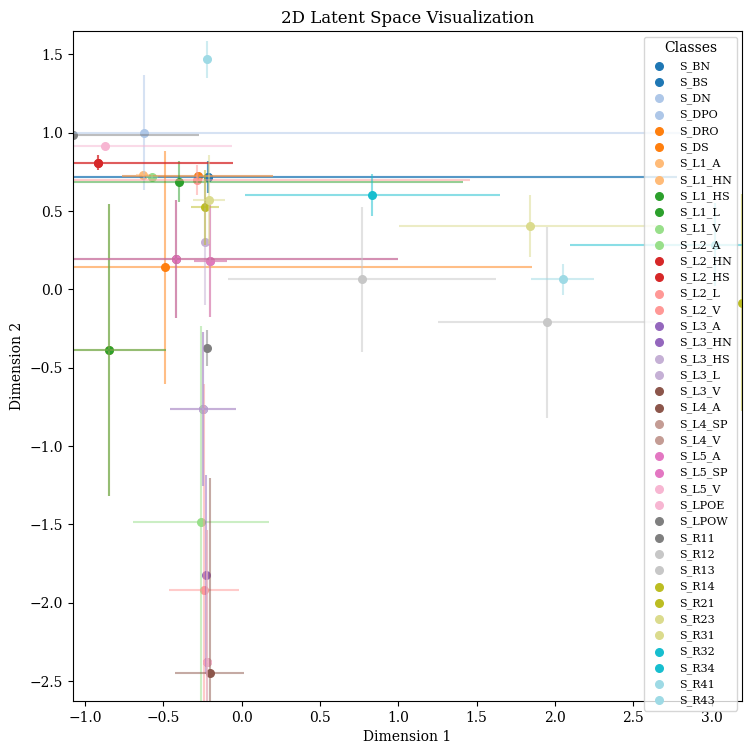

In [52]:
if len(features_used)==2:
    plot_2d_latent_space(feature_centroids,np.array(family_names), latent_stdevs=stdev_centroids)

## Calculate distances

In [53]:
if data.shape[1] == 7:
    no_time_data = data[:,1:,:]
    no_time_refined_orbits = refined_orbits[:,1:,:]
    no_time_generated_data_that_was_refined = generated_data_that_was_refined[:,1:,:]
else:
    no_time_data = data
    no_time_refined_orbits = refined_orbits
    no_time_generated_data_that_was_refined = generated_data_that_was_refined

print(no_time_data.shape)
print(no_time_refined_orbits.shape)
print(no_time_generated_data_that_was_refined.shape)
print(no_time_generation.shape)


(45211, 6, 100)
(46, 6, 100)
(46, 6, 100)
(100, 6, 100)


In [54]:
no_time_generation.shape

(100, 6, 100)

In [55]:
no_time_data.shape

(45211, 6, 100)

1. Nearest Orbit

In [56]:
nearest_indices_generation, nearest_distances_generation = find_nearest_orbits_batch(no_time_generation,
                                                                                     no_time_data,
                                                                                     n=1,
                                                                                     distance_metric=params['distance_metric'])
generation_df['nearest_orbit'] = nearest_indices_generation
generation_df['nearest_orbit_distance'] = nearest_distances_generation

In [57]:
nearest_indices_refined_generation, nearest_distances_refined_generation = find_nearest_orbits_batch(no_time_refined_orbits,
                                                                                                     no_time_data,
                                                                                                     n=1,
                                                                                                     distance_metric=params['distance_metric'])
refined_orbits_df['nearest_orbit'] = nearest_indices_refined_generation
refined_orbits_df['nearest_orbit_distance'] = nearest_distances_refined_generation

2. Generation vs Refinement

In [58]:
pairwise_distances = calculate_pairwise_distances(no_time_generated_data_that_was_refined,
                                                  no_time_refined_orbits,
                                                  distance_metric=params['distance_metric'])
refined_orbits_df['distance_from_generation'] = pairwise_distances

3. Distance from the centre

In [59]:
# Latent space distance
centroid_distances = calculate_distances_batch(full_data_centroid, refined_latent_means, distance_metric=params['distance_metric'])
refined_orbits_df['centroid_distance'] = centroid_distances

In [60]:
#### debug closest orbit is 00000

In [61]:
# Feature distance
# centroid_distances = calculate_distances_batch(feature_centroid, refined_latent_means, distance_metric=params['distance_metric'])
# refined_orbits_df['centroid_distance'] = centroid_distances

4. Distance from centroids

In [62]:
#### distance from closest centroid
# calculate_distances_batch(single_point: np.ndarray, points_array: np.ndarray, distance_metric: str = 'euclidean')

In [63]:
# same in features

## Export Features

In [64]:
generation_df.to_csv(generation_df_path, index=False)
generation_df.shape

(100, 9)

In [65]:
generation_df.head()

,position_error,velocity_error,energy_error,disorder_metric,correct_order,inversions,kendall_tau_distance,nearest_orbit,nearest_orbit_distance
0,0.044936,0.093646,0.074092,204.0,66.0,133.0,0.053737,0,6.745636
1,0.052754,0.154923,0.151754,400.0,61.0,252.0,0.101818,0,6.854908
2,0.108428,0.184346,0.110844,166.0,67.0,113.0,0.045657,0,10.211395
3,0.161681,0.280255,0.334736,210.0,71.0,136.0,0.054949,0,9.275817
4,0.090926,0.138620,0.231564,174.0,74.0,106.0,0.042828,0,8.578484


In [66]:
generation_df['nearest_orbit'].value_counts()

nearest_orbit
0    100
Name: count, dtype: int64

In [67]:
refined_orbits_df.to_csv(refined_orbits_df_path, index=False)
refined_orbits_df.shape

(46, 38)

In [68]:
refined_orbits_df.head()

,id,old_period,period,iterations_convergence,error,initial_pos_x0,initial_pos_y0,initial_pos_z0,initial_vel_x0,initial_vel_y0,initial_vel_z0,final_pos_x0,final_pos_y0,final_pos_z0,final_vel_x0,final_vel_y0,final_vel_z0,disorder_metric,correct_order,inversions,kendall_tau_distance,propagated_position_error,propagated_velocity_error,propagated_energy_error,calculated_jacobi,period_distance_with_generation,feature_distance_from_closest,closest_feature_indices,nearest_orbit,nearest_orbit_distance,distance_from_generation,centroid_distance,disorder_metric,correct_order,inversions,kendall_tau_distance,feature_closest_orbit,feature_distance_from_closest_orbit
0,0,4.517193,4.408274,13,3.425201e-10,1.091727,0.026502,-0.045054,0.033199,-0.119585,-0.064925,1.117204,-0.079060,-1.037362e-01,-0.159310,-0.197419,-2.965951e-01,220.0,61.0,143.0,0.057778,2.531853e-12,6.885720e-12,1.935852e-12,2.984220,0.108919,0.000090,13003,0,7.113193,2.144939,1.017059,220.0,61.0,143.0,0.057778,13003,0.000090
1,2,6.081447,6.093807,6,8.393596e-11,0.765791,-0.062566,-0.300177,-0.089754,-0.046112,-0.773538,0.879347,-0.059126,-2.415599e-01,-0.082026,-0.182004,-7.600174e-01,104.0,75.0,66.0,0.026667,1.526021e-12,5.227806e-12,5.984645e-12,2.395489,0.012360,0.000979,12570,0,9.997017,2.543358,2.111860,104.0,75.0,66.0,0.026667,12570,0.000979
2,4,5.969552,5.799934,8,3.155458e-13,0.730357,0.013235,-0.205358,-0.012986,0.241850,-0.361215,0.880567,-0.013873,-3.554353e-01,-0.034182,-0.020970,-4.391288e-01,222.0,73.0,147.0,0.059394,1.292439e-12,3.252634e-12,2.332590e-14,2.714493,0.169619,0.000037,12670,0,8.356507,2.998624,1.547444,222.0,73.0,147.0,0.059394,12670,0.000037
3,5,6.518158,6.238204,10,2.595689e-10,-1.811148,0.151417,-0.046776,0.051786,1.402418,0.072901,-1.677355,0.129247,5.101010e-09,0.121676,1.248164,-1.050935e-10,188.0,78.0,130.0,0.052525,1.847805e-12,8.638641e-12,5.048687e-11,2.461519,0.279954,0.000004,22681,0,23.384367,4.519528,1.447653,188.0,78.0,130.0,0.052525,22681,0.000004
4,7,4.239129,6.337604,31,8.436388e-13,-0.470492,0.175187,-0.754298,0.204873,1.011473,0.086243,0.044747,0.396483,-1.018880e-01,0.968640,1.244493,1.341746e+00,578.0,63.0,372.0,0.150303,1.770958e-12,4.764018e-12,1.437797e-12,0.687834,2.098476,0.031454,30655,0,21.225327,15.175562,0.450078,578.0,63.0,372.0,0.150303,30655,0.031454


# Intelligent Sampling

In [69]:
# interpolate_sample(centroids, granularity=10, variance=0.0)